<a href="https://colab.research.google.com/github/gromanar/spark-py-nlp-tfm/blob/main/Spark_2_4_Spark_NLP_3_0_x_BERT_classification_1_1_espa%C3%B1ol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !cat /proc/cpuinfo

In [ ]:
GPU=True
if GPU:
  print("GPU Will be used")
  !nvidia-smi

GPU Will be used
Thu Jul 15 07:40:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

In [ ]:
'''
para evitar que se ponga en off, hacer ctrol + shift + i y luego a consola
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
'''

'\npara evitar que se ponga en off, hacer ctrol + shift + i y luego a consola\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n'

In [ ]:
!lsb_release -a
# !wget http://setup.johnsnowlabs.com/colab.sh && cat colab.sh

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [ ]:
print( "setup Colab para PySpark y Spark NLP ")
!apt-get update
!apt-get purge -y openjdk-11* -qq > /dev/null && sudo apt-get autoremove -y -qq > /dev/null
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

setup Colab para PySpark y Spark NLP 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [62.2 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]

In [ ]:
# !conda create -n sparknlp python=3.7 -y
!conda activate sparknlp
# !pip install spark-nlp==3.0.2 pyspark==3.1.1 # para spark 3 pero no tira
!pip install spark-nlp==3.0.3 pyspark==2.4.7


/bin/bash: conda: command not found
     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 217.9MB 60kB/s 
     |████████████████████████████████| 204kB 18.6MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.7-py2.py3-none-any.whl size=218279468 sha256=52f4250376bbb7bdd031c8b055e5d8df6cb0cb5df7f763ce049485ee160fc9fd
  Stored in directory: /root/.cache/pip/wheels/34/1f/2e/1e7460f80acf26b08dbb8c53d7ff9e07146f2a68dd5c732be5
Successfully built pyspark


In [ ]:
# export SPARK_HOME=$SPARKHOME
# export JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

# # Install pyspark spark-nlp
# ! pip install --upgrade -q pyspark==$PYSPARK spark-nlp==$SPARKNLP findspark

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import *

# spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd

# para las puntuaciones
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import preprocessing

from sparknlp.base import LightPipeline

In [ ]:
import seaborn as sns
# from sklearn.metrics import , classification_report
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [ ]:
import time
inicio = time.time()

In [ ]:
# from pyspark.sql import SparkSession
# choose gpu/cpu 
if GPU:
  #sparknlp="com.johnsnowlabs.nlp:spark-nlp-gpu_2.12:3.0.2"
  sparknlp="com.johnsnowlabs.nlp:spark-nlp-gpu-spark24_2.11:3.0.3"
else:
  #sparknlp="com.johnsnowlabs.nlp:spark-nlp_2.12:3.0.2"
  sparknlp="com.johnsnowlabs.nlp:spark-nlp-spark24_2.11:3.0.3"
spark = (SparkSession.builder
              .master("local[*]")
              .appName("Spark NLP Classification")
              .config("spark.driver.memory","10G")  # maximo 12
              .config("spark.driver.maxResultSize", "0") 
              .config("spark.kryoserializer.buffer.max", "2000M")
              .config("spark.jars.packages", sparknlp)
              .getOrCreate()
   )
spark

In [ ]:
import sparknlp
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.0.3
Apache Spark version: 2.4.7


Crear funciones propias y ejecutandolas con `UDF` de pyspark.sql.functions

# 1. Read data

### download data

In [ ]:
!pip install awscli

     |████████████████████████████████| 3.6MB 4.2MB/s 
     |████████████████████████████████| 552kB 38.7MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 7.7MB 34.0MB/s 
     |████████████████████████████████| 143kB 41.5MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# !aws s3 ls s3://amazon-reviews-ml/json/train/ --no-sign-request
# https://docs.aws.amazon.com/cli/latest/reference/dataexchange/get-data-set.html
# https://registry.opendata.aws/amazon-reviews-ml/ --> información al dataset

In [ ]:
!aws s3 cp s3://amazon-reviews-ml/json/test/dataset_es_test.json ./sample_data/ --no-sign-request
!aws s3 cp s3://amazon-reviews-ml/json/train/dataset_es_train.json ./sample_data/ --no-sign-request

download: s3://amazon-reviews-ml/json/test/dataset_es_test.json to sample_data/dataset_es_test.json
download: s3://amazon-reviews-ml/json/train/dataset_es_train.json to sample_data/dataset_es_train.json


In [ ]:
# !wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_train.csv -P ./sample_data -q
# !wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_test.csv -P ./sample_data -q

In [ ]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00259/rcv1rcv2aminigoutte.tar.bz2 -P ./sample_data -q
# !tar -tf ./sample_data/rcv1rcv2aminigoutte.tar.bz2
# !tar -xf ./sample_data/rcv1rcv2aminigoutte.tar.bz2 rcv1rcv2aminigoutte/SP/ -C ./sample_data/
# !head /content/rcv1rcv2aminigoutte/SP/Index_SP-SP

In [ ]:
!ls ./sample_data

anscombe.json		      dataset_es_test.json   mnist_train_small.csv
california_housing_test.csv   dataset_es_train.json  README.md
california_housing_train.csv  mnist_test.csv


In [ ]:

# Si queremos hacer el split al dataset
'''
(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
'''

'\n(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)\nprint("Training Dataset Count: " + str(trainingData.count()))\nprint("Test Dataset Count: " + str(testData.count()))\n'

In [ ]:
root_folder = "./sample_data/"
# traindata = root_folder + "news_category_train.csv"
# testdata = root_folder + "news_category_test.csv"
traindata = root_folder + "dataset_es_train.json"
testdata = root_folder + "dataset_es_test.json"

In [ ]:
trainDataset = spark.read \
      .option("header", True) \
      .json(traindata)
      #.csv(traindata)
trainDataset.show(10, truncate=50)

+--------+----------------+------------------+--------------------------------------------------+----------+--------------------------------------------------+-------------------+-----+
|language|product_category|        product_id|                                       review_body| review_id|                                      review_title|        reviewer_id|stars|
+--------+----------------+------------------+--------------------------------------------------+----------+--------------------------------------------------+-------------------+-----+
|      es|     electronics|product_es_0296024|Nada bueno se me fue ka pantalla en menos de 8 ...|es_0491108|                                  television Nevir|reviewer_es_0999081|    1|
|      es|     electronics|product_es_0922286|Horrible, nos tuvimos que comprar otro porque n...|es_0869872|         Dinero tirado a la basura con esta compra|reviewer_es_0216771|    1|
|      es|       drugstore|product_es_0474543|Te obligan a comprar dos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


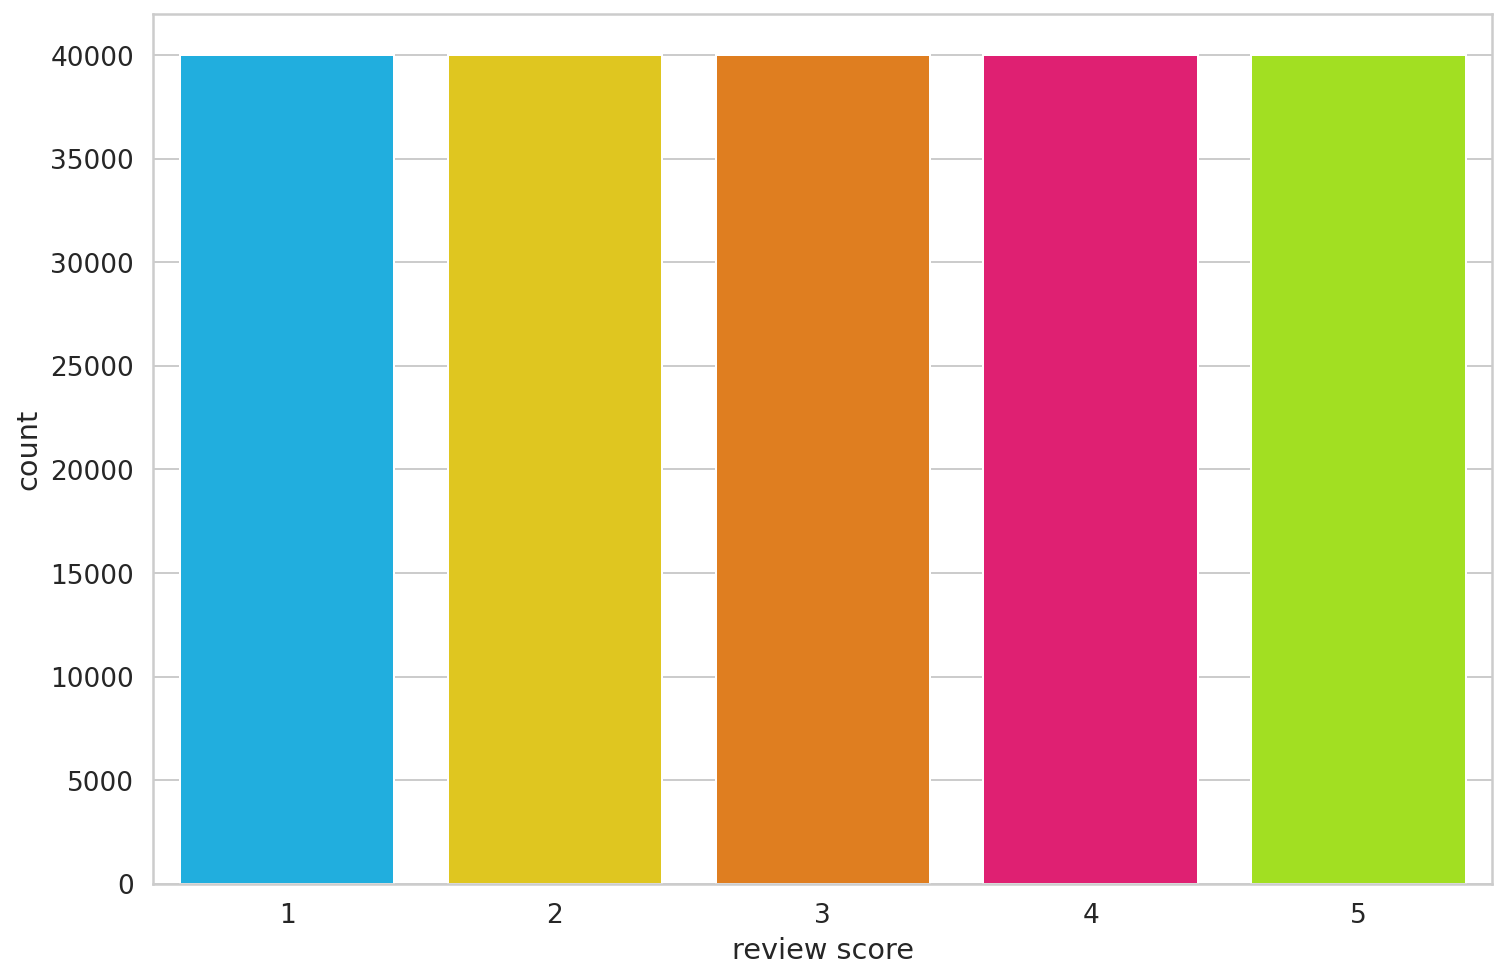

In [ ]:
sns.countplot(trainDataset.select("stars").rdd.flatMap(lambda x: x).collect())
plt.xlabel('review score');


In [ ]:
trainDataset = trainDataset.withColumn("sentiment",F.when(col("stars")<=2,0).when(col("stars")==3,1).otherwise(2))

In [ ]:
temp_ds = trainDataset.filter("sentiment==0").limit(40000)
temp_ds = temp_ds\
  .unionByName(trainDataset.filter("sentiment==1"))\
  .unionByName(trainDataset.filter("sentiment==2").limit(40000))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


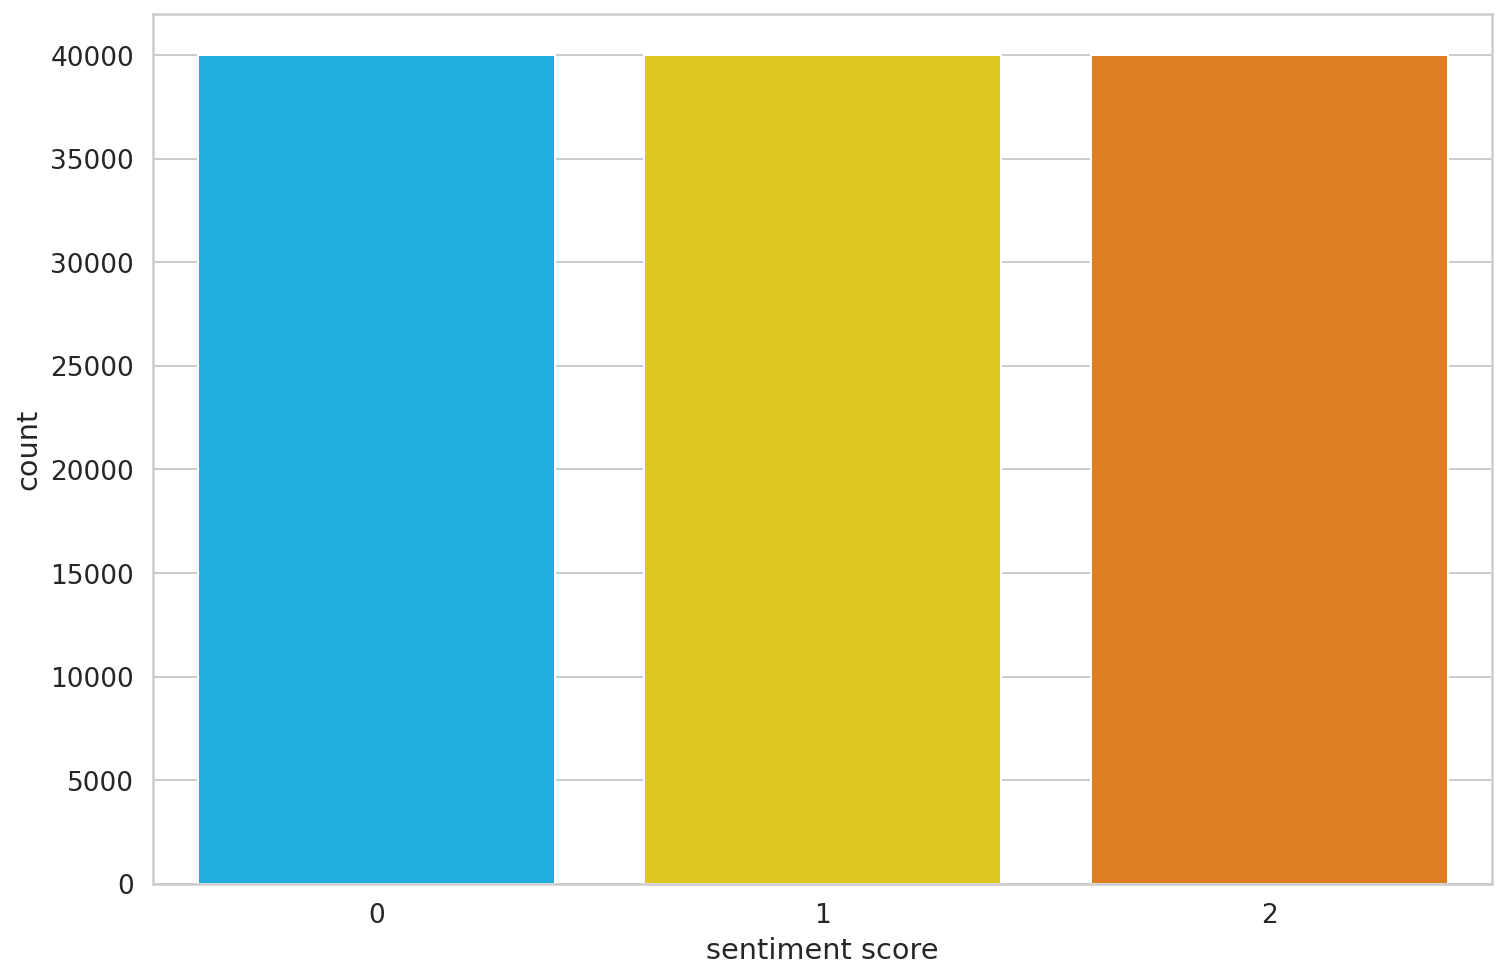

In [ ]:
# tenemos problema de 
sns.countplot(temp_ds.select("sentiment").rdd.flatMap(lambda x: x).collect())
plt.xlabel('sentiment score');
trainDataset = temp_ds

In [ ]:
# renombramos el dataset temporal al de entrenamiento.
trainDataset = temp_ds

# 2. Explore data

In [ ]:
print("el numero de particiones es: ",trainDataset.rdd.getNumPartitions())
# Let's do a full-shuffle with the repartition method and get this data on two nodes.
trainDataset = trainDataset.repartition(200)
print("el numero de particiones despues de la reparticion es (a parTe que se ha hecho fullsuffle) : ",trainDataset.rdd.getNumPartitions())

el numero de particiones es:  4
el numero de particiones despues de la reparticion es (a parTe que se ha hecho fullsuffle) :  200


In [ ]:
trainDataset.groupBy("sentiment") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()


+---------+-----+
|sentiment|count|
+---------+-----+
|        1|40000|
|        2|40000|
|        0|40000|
+---------+-----+



# 3. Create Test

In [ ]:
testDataset = spark.read \
      .option("header", True) \
      .json(testdata)

testDataset = testDataset.withColumn("sentiment",F.when(col("stars")<=2,0).when(col("stars")==3,1).otherwise(2))

temp_ds = testDataset.filter("sentiment==0").limit(1000)
testDataset = temp_ds\
  .unionByName(testDataset.filter("sentiment==1"))\
  .unionByName(testDataset.filter("sentiment==2").limit(1000))

testDataset.groupBy("sentiment") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+---------+-----+
|sentiment|count|
+---------+-----+
|        2| 1000|
|        1| 1000|
|        0| 1000|
+---------+-----+



## CONFIGURACIÓN DE LOS MODELOS PREENTRENADOS BERT

>CONSULTAR LOS MODELOS PREENTRENADOS DISPONIBLES [AQUI](https://nlp.johnsnowlabs.com/models)



In [ ]:
def experimento(tipo: str, idioma: str):
  if tipo.upper()=="A":
    BATCH_SIZE = 16
    EPOCHS = 2
    LEARNING_RATE = 5e-5
  elif tipo.upper()=="B":
    BATCH_SIZE = 32
    EPOCHS = 4
    LEARNING_RATE = 3e-5
  else:
      print("elige experimento")
  
  if idioma.upper()=="EN":
    PRE_TRAINED_MODEL_NAME = 'small_bert_L4_256'
  elif idioma.upper()=="ES":
    PRE_TRAINED_MODEL_NAME = 'bert_multi_cased'
  else:
    print("modelo no elegido")
  return BATCH_SIZE, EPOCHS, LEARNING_RATE,PRE_TRAINED_MODEL_NAME



In [ ]:
BATCH_SIZE, EPOCHS, LEARNING_RATE, PRE_TRAINED_MODEL_NAME = experimento(tipo = "a", idioma ="es")


SENTENCE_PRE_TRAINED_MODEL_NAME = 'sent_'+PRE_TRAINED_MODEL_NAME

# Original values
# PRE_TRAINED_MODEL_NAME = 'bert_base_cased' # 389.1 MB
# PRE_TRAINED_MODEL_NAME = 'sent_small_bert_L8_512' 149.1 MB
# PRE_TRAINED_MODEL_NAME = 'small_bert_L4_256' 40.5 MB

# Para sentence embeddings.
# SENTENCE_PRE_TRAINED_MODEL_NAME = 'sent_bert_base_cased'
# SENTENCE_PRE_TRAINED_MODEL_NAME = 'sent_small_bert_L8_512' # 149.1 MB


# set learning rate 
# learning_rate = 0.001
# learning_rate = 2e-5




# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

In [ ]:
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"LEARNING_RATE: {LEARNING_RATE}")
print(f"EPOCHS: {EPOCHS}")
print(f"PRE_TRAINED_MODEL_NAME: {PRE_TRAINED_MODEL_NAME}")
print(f"PRE_TRAINED_MODEL_NAME FOR SENTENCES: {SENTENCE_PRE_TRAINED_MODEL_NAME}")

BATCH_SIZE: 16
LEARNING_RATE: 5e-05
EPOCHS: 2
PRE_TRAINED_MODEL_NAME: bert_multi_cased
PRE_TRAINED_MODEL_NAME FOR SENTENCES: sent_bert_multi_cased


# 4. Clasificación de textos usando BERT EMBEDDINGS

Naming conventions in Spark NLP Bert models. L indicates which pooling layer is used while producing the embeddings and H mean the dimension of the embeddings returned. 

L indica que pooling layer se usa mientras se producen las ingestas y 
H significa la dimensión que se devuelve de esos embeddings

[ver lista](https://github.com/JohnSnowLabs/spark-nlp-models)

- utilizamos `BertSentenceEmbeddings` == `'sent_small_bert_L8_512'`

  Simplemente cargamos `Bert Sentence Embeddings Small` con dimensión L8 y 512 y usamos eso en lugar de USE. Como puede ver, es casi 8 veces más pequeño que el tamaño de USE con el poder de Bert. 

El modelo se puede utilizar de manera offline si se desea, pero habria que descargarlo previamente.

De esta manera dejamos a SPARK_NLP que lo baje automáticamente.




In [ ]:
(time.time() - inicio)/60

2.0121896107991537

**BERT EMBEDDINGS**

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("review_body") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# BertEmbeddings utiliza los datos de una red neuronal entrenada previamente (el nombre del modelo) para crear codificar las palabras que contiene cada texto 
# convirtiendo a vectores dichas palabras. (codificandolas) AQUI USE AL PRINCIPIO 'small_bert_L4_256'
bert_embeddings = BertEmbeddings().pretrained(name=PRE_TRAINED_MODEL_NAME, lang='xx') \
    .setInputCols(["document",'token'])\
    .setOutputCol("embeddings")
#
embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")
# ClassifierDLApproach: ClassifierDL Utiliza el State-of-the-art de las Universal Sentence Encoder como input para iniciar clasificaciones de texto.
# es un clasificador que contiene casi 100 clases de tensorflow, usa modelos de deep learning DNN
# LR 5e-3f BATCHSIZE 8
classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("sentiment")\
    .setMaxEpochs(EPOCHS)\
    .setLr(LEARNING_RATE)\
    .setBatchSize(BATCH_SIZE)\
    .setEnableOutputLogs(True)
    #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(stages=[
    document_assembler, 
    tokenizer,
    bert_embeddings,
    embeddingsSentence,
    classsifierdl
])


bert_multi_cased download started this may take some time.
Approximate size to download 638.6 MB
[OK!]


## 4.1 Ajuste del modelo (FIT)

In [ ]:
%%time
bert_Model = bert_clf_pipeline.fit(trainDataset) #
# GPU
# CPU times: user 8.61 s, sys: 797 ms, total: 9.41 s
# Wall time: 36min 43s

CPU times: user 23.5 s, sys: 2.98 s, total: 26.5 s
Wall time: 1h 17min 51s


In [ ]:
(time.time() - inicio)/60
# bert_Model.withColumn("tmp", F.explode("chunk")).select("tmp.*")

88.0389175216357

## 4.2 realizamos predicciones en el conjunto de prueba 

In [ ]:
# prueba ligera
light_model = LightPipeline(bert_Model)

light_result = light_model.annotate("Este producto es un poco asqueroso, no me ha gustado nada")
print(light_result)

{'document': ['Este producto es un poco asqueroso, no me ha gustado nada'], 'sentence_embeddings': ['Este producto es un poco asqueroso, no me ha gustado nada'], 'token': ['Este', 'producto', 'es', 'un', 'poco', 'asqueroso', ',', 'no', 'me', 'ha', 'gustado', 'nada'], 'class': ['0'], 'embeddings': ['Este', 'producto', 'es', 'un', 'poco', 'asqueroso', ',', 'no', 'me', 'ha', 'gustado', 'nada']}


In [ ]:
predict_bert = bert_Model.transform(testDataset)

predict_bert.select("sentiment","review_body","class.result").show(10,truncate=80)

+---------+--------------------------------------------------------------------------------+------+
|sentiment|                                                                     review_body|result|
+---------+--------------------------------------------------------------------------------+------+
|        0|no me llego el articulo me lo mando por correos normal sin seguimiento y nunc...|   [0]|
|        0|                                           la mensajería horrible, no compro mas|   [0]|
|        0|Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo ...|   [0]|
|        0|Mi valoración no es sobre el producto sino sobre AMAZON. Ofrecéis el producto...|   [0]|
|        0|Pues tenía interés en este libro y probé la versión kindle. se abre la portad...|   [0]|
|        0|Compre este teclado al ver sus buenos comentarios y apariencia pero al llegar...|   [0]|
|        0|                                               Sigue sin llegar después de meses|   [0]|


In [ ]:
(time.time() - inicio)/60

88.08658401966095

## 4.3 Obtenemos el rendimiento del modelo para comparar con la opcion de USE


In [ ]:
df=bert_Model.transform(testDataset).selectExpr("cast(sentiment as int) as sentiment","review_body","class.result").toPandas()
# extraemos el resultado de la lista
df.result=df.result.apply(lambda x: int(x[0]))

class_names = ['negative', 'neutral', 'positive']

print(classification_report(df.sentiment, df.result,target_names=class_names))
print(accuracy_score(df.sentiment, df.result))

              precision    recall  f1-score   support

    negative       0.67      0.76      0.71      1000
     neutral       0.49      0.42      0.45      1000
    positive       0.59      0.61      0.60      1000

    accuracy                           0.59      3000
   macro avg       0.59      0.59      0.59      3000
weighted avg       0.59      0.59      0.59      3000

0.594


In [ ]:
# from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# df["category_encoded"]=le.fit_transform(df.category)
# df_testdata["category_encoded"]=le.fit_transform(df_testdata.category)
# class_names=trainDataset.groupBy("category").count().select("category").rdd.flatMap(lambda x: x).collect()
# class_names.sort()
# class_names



In [ ]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# from matplotlib import rc
# from pylab import rcParams
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# rcParams['figure.figsize'] = 12, 8



def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');



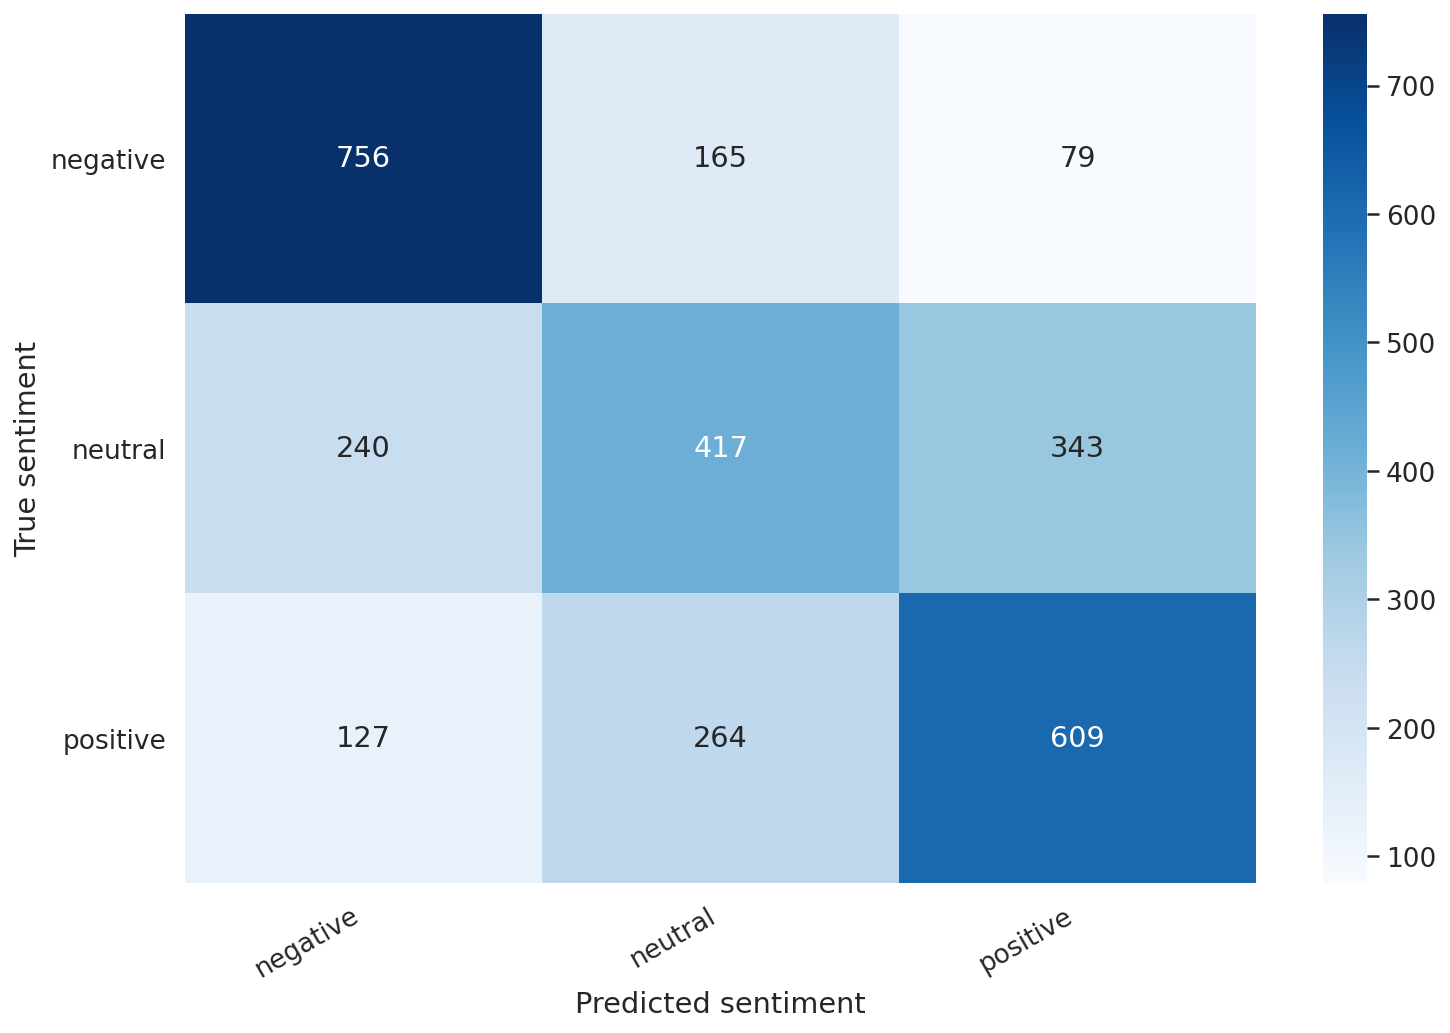

In [ ]:
cm = confusion_matrix(df.sentiment, df.result)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## 5. BERT SENTENCE EMBEDDINGS CLASsIFICATION MODEL


In [ ]:
# actual content is inside description column
document_assembler = DocumentAssembler() \
    .setInputCol("review_body") \
    .setOutputCol("document")


# we can also use sentece detector here if we want to train on and get predictions for each sentence
# las palabras o frases del lenguaje natural son representadas como vectores
bert_sent = BertSentenceEmbeddings.pretrained(SENTENCE_PRE_TRAINED_MODEL_NAME,lang='xx')\
      .setInputCols(["document"])\
      .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in sentiment column
# MAX EPOCHS IN THIS WAS 10
classsifierdl = ClassifierDLApproach()\
      .setInputCols(["sentence_embeddings"])\
      .setOutputCol("class")\
      .setLabelColumn("sentiment")\
      .setMaxEpochs(EPOCHS)\
      .setEnableOutputLogs(True)\
      .setLr(LEARNING_RATE)\
      .setBatchSize(BATCH_SIZE)

bert_sent_clf_pipeline = Pipeline(
    stages = [
        document_assembler,
        bert_sent,
        classsifierdl
    ])

sent_bert_multi_cased download started this may take some time.
Approximate size to download 638.6 MB
[OK!]


In [ ]:
%%time
bert_sent_pipelineModel = bert_sent_clf_pipeline.fit(trainDataset)
# GPU
# CPU times: user 2.67 s, sys: 300 ms, total: 2.97 s
# Wall time: 12min 27s

In [ ]:
# We are going to use sklearn to evalute the results on test dataset Usamos sklearn para eValuar los resultados en el conjunto de datos de prueba.
# from sklearn.metrics import classification_report

preds = bert_sent_pipelineModel.transform(testDataset)

preds_df = preds.select('sentiment','review_body',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))

print(classification_report(preds_df.sentiment, preds_df.result))
print(accuracy_score(preds_df['sentiment'], preds_df['result']))

In [ ]:
cm = confusion_matrix(preds_df.sentiment, preds_df.result)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

**TOMAMOS PREDICCION DEL MODELO**

In [ ]:
# from sparknlp.base import LightPipeline

light_model = LightPipeline(bert_sent_pipelineModel)

In [ ]:
testDataset.select('review_body').take(2)

In [ ]:
text='''
Creo que el producto ha estado bien, sin embargo, el tema de que no pudiera hacer lo que dijo ha terminado siendo un rollo y lo vamos a devolver. 
'''
result = light_model.annotate(text)

result['class']

In [ ]:
light_model.annotate('the soccer games will be postponed.')

In [ ]:
light_model.annotate(
    "Me encanta, lo recomendaría al 100%, no se como no se lo han comprado antes."
)["class"]

# Pipeline COMPLETO de clasificación con ML 

Ahora vamos a aplicar ese modelo, realizando un poquito de preprocesado para los datos.



1.   Creamos el corpus para el input del modelo
2.   tokenizamos.
3.   normalizamos.
4.   quitamos stopwords (palabras que no aportan información)
5.   lemmatizer, busca la paplabra raiz, se diferencia del stemmer a que no recorta la palabra hasta quitarle el sentido. books --> book 
6.   word embeddings no se
7.   sentence embeddings no se
8.   clasificador





In [ ]:
# doccument_assembler = DocumentAssembler()\
#       .setInputCol("text")\
#       .setOutputCol("document")

# tokenizer = Tokenizer()\
#       .setInputCols(["document"])\
#       .setOutputCol("token")

# normalizer = Normalizer()\
#       .setInputCols(["token"])\
#       .setOutputCol("normalized")

# stopwords_cleaner = StopWordsCleaner()\
#       .setInputCols(["normalized"])\
#       .setOutputCol("cleanTokens")\
#       .setCaseSensitive(False)
  
# lemma = LemmatizerModel.pretrained("lemma_antbnc")\
#       .setInputCols(["cleanTokens"])\
#       .setOutputCol("lemma")

# #  en lugar de usar embeddings USE podemos usar el bert, que es el que usarmemos en el modelo final.
# word_embeddings_use = WordEmbeddingsModel().pretrained()\
#       .setInputCols(["document","lemma"])\
#       .setOutputCol("embeddings")

# # este modelo --> 'bert_base_cased' para realizar el embeddings pesa bastante, quiza buscar uno mas peq.
# word_embeddings_bert = BertEmbeddings\
#     .pretrained(PRE_TRAINED_MODEL_NAME, 'en') \
#     .setInputCols(["document",'lemma'])\
#     .setOutputCol("embeddings")\

# # al igual que en las frases

# embeddingsSentence = (SentenceEmbeddings()                   
#                    .setInputCols(["document","embeddings"])
#                    .setOutputCol("sentence_embeddings")
#                    .setPoolingStrategy('AVERAGE')
#                    )
# # este era el modelo para crear las sentence embeddings con BERT 'sent_small_bert_L8_512'
# embeddingsSentence_bert = (BertSentenceEmbeddings
#                    .pretrained(SENTENCE_PRE_TRAINED_MODEL_NAME)
#                    .setInputCols(["document","embeddings"])
#                    .setOutputCol("sentence_embeddings"))


# classifierdl = (ClassifierDLApproach()
#   .setInputCols(["sentence_embeddings"])
#   .setOutputCol("class")
#   .setLabelColumn("category")
#   .setMaxEpochs(20)
#   .setEnableOutputLogs(True)
# )

# clf_pipeline = Pipeline(
#     stages = [
#               doccument_assembler,
#               tokenizer,
#               normalizer,
#               stopwords_cleaner,
#               lemma,
#               word_embeddings_bert,
#               embeddingsSentence_bert,
#               classifierdl
#               ])

In [ ]:
# trainDataset.show()

In [ ]:
# %%time
# clf_pipelineModel = clf_pipeline.fit(trainDataset)

realizamos una prueba pequeña "light"

In [ ]:
# light_model = LightPipeline(clf_pipelineModel)

# light_result = light_model.annotate("John and Peter are brothers. However they don't support each other that much.")


### vermos las metricas y el rendimiento

In [ ]:
# df = clf_pipelineModel.transform(testDataset).select("category","description","class.result").toPandas()
# # extraemos el resultado de la lista
# df.result=df.result.apply(lambda x: x[0])

# print(classification_report(df.category, df.result))
# print(accuracy_score(df.category, df.result))

In [ ]:
(time.time() - inicio)/60

In [ ]:
# from pyspark.sql.functions import udf

# bibliografia

In [ ]:
# seguir este tutor
# https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb

# todas las opciones de preprocesado
# https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/2.Text_Preprocessing_with_SparkNLP_Annotators_Transformers.ipynb
# https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32
# como instalar
# https://nlp.johnsnowlabs.com/docs/en/install#offline
# siguiente paso, hacerlo en python normal
# https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=OjwJ4bTeWXD8
# https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb
# https://github.com/google-research/bert


# para explicar las ventajas de Spark NLP vs Spacy
# https://towardsdatascience.com/introduction-to-spark-nlp-foundations-and-basic-components-part-i-c83b7629ed59

# explicacionb de bert en dIapositivas
# http://web.stanford.edu/class/cs224n/slides/Jacob_Devlin_BERT.pdf

# información 
# https://research.google.com/colaboratory/faq.html#gpu-availability